In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers

In [43]:
tf.__version__

'2.9.1'

# Breast Cancer Wisconsin with TensorFlow

In this notebook you will learn how to classify structured data using Keras preprocessing layers. You will use [Keras](https://www.tensorflow.org/guide/keras) to define the model, and [preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) as a bridge to map from columns in a CSV to features used to train the model. 

The content is based on a [tutorial](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers) from the TensorFlow team. Some utility functions used in this notebook are copied from this tutorial and we recommend to refer to it for more details.

You will train and deploy a Neural Network to predict whether breast cancer is benign or malignant (see [Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/data) at Kaggle).

### Use Pandas to create a dataframe

Import training data from public Github URL and load it into a dataframe.

In [44]:
dataset_url = "https://raw.githubusercontent.com/ellenhvn/hhz-artificial-intelligence-vl-ws23/main/Exercise%20Material/Cancer%20with%20Tensorflow/data.csv"
csv_file = tf.keras.utils.get_file("data.csv", dataset_url, cache_dir=".")
dataframe_unmodified = pd.read_csv(csv_file)

In [45]:
dataframe_unmodified.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Prepare data

Data preparation and analysis for this dataset was covered in depth in a different notebook (see "[HHZ] Cancer (Exercise)").

In [46]:
dataframe = dataframe_unmodified.copy()

In [47]:
# check for missing values
dataframe.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [48]:
# map malignant (denoted by "M") to 1 and benign (denoted by "B") to 0
dataframe.diagnosis.replace(["M", "B"], [1, 0], inplace=True)

In [49]:
# rename inconsistently named columns
dataframe.rename(
    columns={
        "concave points_mean": "concave_points_mean",
        "concave points_worst": "concave_points_worst",
        "concave points_se": "concave_points_se",
    },
    inplace=True,
)

# Note: without this transformation tf.keras.models.load_model may fail in the last step with a confusing error message if these columns are used as a predictor.

In [50]:
dataframe.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Split the dataframe into train, validation, and test

In [51]:
train, val, test = np.split(
    dataframe.sample(frac=1), [int(0.8 * len(dataframe)), int(0.9 * len(dataframe))]
)

print(f"{len(train)} train examples")
print(f"{len(val)} validation examples")
print(f"{len(test)} test examples")

455 train examples
57 validation examples
57 test examples


### Create an input pipeline using tf.data

Next, you will wrap the dataframes with tf.data, in order to shuffle and batch the data. If you were working with a very large CSV file (so large that it does not fit into memory), you would use tf.data to read it from disk directly. That is not covered in this tutorial.

Note: Below utility functions are copied from https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers and have been adapted for our use-case.

In [52]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop("diagnosis")
    df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

Now that you have created the input pipeline, let's call it to see the format of the data it returns. You have used a small batch size to keep the output readable.

In [53]:
batch_size = 5
train_ds = df_to_dataset(train, shuffle=False, batch_size=batch_size)

/var/folders/ng/4m4yl74d5pgcr1p5b4gy6vxr0000gn/T/ipykernel_83831/895198744.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}


In [54]:
[(train_features, label_batch)] = train_ds.take(1)
print(f"Every feature: {list(train_features.keys())}")
print(f'A batch of mean symmetry values: {train_features["symmetry_mean"]}')
print(f"A batch of targets {label_batch}")

Every feature: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst']
A batch of mean symmetry values: [[0.1533]
 [0.1809]
 [0.1734]
 [0.2403]
 [0.1909]]
A batch of targets [0 0 0 0 1]


In [55]:
# check documentation for details:
# - https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

All potential features are numeric. The only layer type we need in this exampleis a "normalization layer". Let's take a look at an example to see how the encoding works:

*Create a normalization layer for 'symmetry_mean'*

In [56]:
symmetry_mean_col = train_features["symmetry_mean"]
symmetry_mean_col

<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[0.1533],
       [0.1809],
       [0.1734],
       [0.2403],
       [0.1909]])>

In [57]:
layer = get_normalization_layer("symmetry_mean", train_ds)
layer(symmetry_mean_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.98681515],
       [ 0.00761579],
       [-0.26260984],
       [ 2.1478052 ],
       [ 0.36791718]], dtype=float32)>

#### Choose which columns to use

You have seen how to use several types of preprocessing layers. Now you will use them to train a model. You will be using [Keras-functional API](https://www.tensorflow.org/guide/keras/functional) to build the model. The Keras functional API is a way to create models that are more flexible than the [tf.keras.Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential).

In [58]:
batch_size = 64
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

/var/folders/ng/4m4yl74d5pgcr1p5b4gy6vxr0000gn/T/ipykernel_83831/895198744.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
/var/folders/ng/4m4yl74d5pgcr1p5b4gy6vxr0000gn/T/ipykernel_83831/895198744.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}


In [59]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    int64  
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [60]:
# option 1: a suitable subset of predictors (e.g. predictors that are not correlated)
feature_columns1 = [
    "radius_mean",
    "smoothness_mean",
    "compactness_mean",
    "symmetry_mean",
    "fractal_dimension_mean",
    "radius_se",
    "texture_se",
    "smoothness_se",
    "compactness_se",
    "symmetry_se",
    "fractal_dimension_se",
    "symmetry_worst",
]

In [61]:
# option 2: all predictors except for the id because we know the id is just a random number without an impact on the result
feature_columns2 = dataframe.columns.drop(["id", "diagnosis"])

In [62]:
feature_columns = feature_columns1

In [63]:
all_inputs = []
encoded_features = []

# Numeric features.
for header in feature_columns:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

#### Create, compile, and train the model

In [64]:
all_features = tf.keras.layers.concatenate(encoded_features)
x1 = tf.keras.layers.Dense(32, activation="relu")(all_features)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x1)
model = tf.keras.Model(all_inputs, output)
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [65]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 radius_mean (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 smoothness_mean (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 compactness_mean (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 symmetry_mean (InputLayer)     [(None, 1)]          0           []                               
                                                                                            

In [66]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50


/Users/ellenhoeven/opt/anaconda3/envs/hhz-tf-39/lib/python3.9/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['id', 'diagnosis', 'texture_mean', 'perimeter_mean', 'area_mean', 'concavity_mean', 'concave_points_mean', 'perimeter_se', 'area_se', 'concavity_se', 'concave_points_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst', 'fractal_dimension_worst'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/Users/ellenhoeven/opt/anaconda3/envs/hhz-tf-39/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


8/8 [==============================] - 0s 21ms/step - loss: 0.7550 - accuracy: 0.4396 - val_loss: 0.7477 - val_accuracy: 0.4561
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 0.6827 - accuracy: 0.5560 - val_loss: 0.6829 - val_accuracy: 0.5439
Epoch 3/50
8/8 [==============================] - 0s 2ms/step - loss: 0.6227 - accuracy: 0.6505 - val_loss: 0.6286 - val_accuracy: 0.6667
Epoch 4/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5738 - accuracy: 0.7209 - val_loss: 0.5830 - val_accuracy: 0.7544
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 0.5318 - accuracy: 0.7714 - val_loss: 0.5426 - val_accuracy: 0.8070
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 0.4970 - accuracy: 0.8022 - val_loss: 0.5092 - val_accuracy: 0.8421
Epoch 7/50
8/8 [==============================] - 0s 3ms/step - loss: 0.4655 - accuracy: 0.8286 - val_loss: 0.4808 - val_accuracy: 0.8596
Epoch 8/50
8/8 [============================

Review how training and validation accuracy evolved

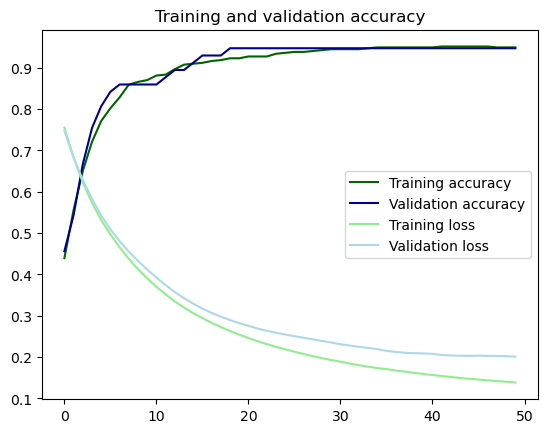

<Figure size 640x480 with 0 Axes>

In [67]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, "darkgreen", label="Training accuracy")
plt.plot(epochs, val_acc, "darkblue", label="Validation accuracy")
plt.plot(epochs, loss, "lightgreen", label="Training loss")
plt.plot(epochs, val_loss, "lightblue", label="Validation loss")
plt.title("Training and validation accuracy")
plt.legend(loc=0)
plt.figure()


plt.show()

In [68]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1/1 [==============================] - 0s 20ms/step - loss: 0.2076 - accuracy: 0.8947
Accuracy 0.8947368264198303


### Evaluate the model (confusion matrix)

In [69]:
y_pred = model.predict(test_ds)

1/1 [==============================] - 0s 91ms/step


In [70]:
predicted_categories = tf.round(y_pred)

In [71]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)

In [72]:
true_categories

<tf.Tensor: shape=(57,), dtype=int64, numpy=
array([1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0])>

In [73]:
# yields count of true negatives, false positives, false negatives, true positives
confusion_matrix(predicted_categories, true_categories)

array([[33,  5],
       [ 1, 18]])

In [74]:
# check that tp, fp, tn, fn are not confused
tn, fp, fn, tp = confusion_matrix(true_categories, predicted_categories).ravel()
print(tn, fp, fn, tp)

33 1 5 18


In [75]:
# yields class-specific precision, recall and f1-score
print(classification_report(true_categories, predicted_categories))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92        34
           1       0.95      0.78      0.86        23

    accuracy                           0.89        57
   macro avg       0.91      0.88      0.89        57
weighted avg       0.90      0.89      0.89        57



Try different neural network configurations (e.g. add additional layers, change the number of neurons per layer, or train for more epochs). Do you get a better results than using the initial configuration?

Continue once you are satisfied with the results.

### Perform inference

Save model to filesystem and reload it for test purposes.

In [76]:
model.save("breast_cancer_model/1")
reloaded_model = tf.keras.models.load_model("breast_cancer_model/1")

INFO:tensorflow:Assets written to: breast_cancer_model/1/assets


Make a local prediction with the aid of the reloaded model

In [77]:
sample_row_df = dataframe.iloc[102:103]
sample_row_df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
102,862965,0,12.18,20.52,77.22,458.7,0.08013,0.04038,0.02383,0.0177,...,13.34,32.84,84.58,547.8,0.1123,0.08862,0.1145,0.07431,0.2694,0.06878


In [78]:
# drop target ('diagnosis') from record
sample_row_df = sample_row_df.drop(["diagnosis"], axis=1)

In [79]:
sample_row_dict = sample_row_df.to_dict(orient="records")[0]
sample_row_dict

{'id': 862965,
 'radius_mean': 12.18,
 'texture_mean': 20.52,
 'perimeter_mean': 77.22,
 'area_mean': 458.7,
 'smoothness_mean': 0.08013,
 'compactness_mean': 0.04038,
 'concavity_mean': 0.02383,
 'concave_points_mean': 0.0177,
 'symmetry_mean': 0.1739,
 'fractal_dimension_mean': 0.05677,
 'radius_se': 0.1924,
 'texture_se': 1.571,
 'perimeter_se': 1.183,
 'area_se': 14.68,
 'smoothness_se': 0.00508,
 'compactness_se': 0.006098,
 'concavity_se': 0.01069,
 'concave_points_se': 0.006797,
 'symmetry_se': 0.01447,
 'fractal_dimension_se': 0.001532,
 'radius_worst': 13.34,
 'texture_worst': 32.84,
 'perimeter_worst': 84.58,
 'area_worst': 547.8,
 'smoothness_worst': 0.1123,
 'compactness_worst': 0.08862,
 'concavity_worst': 0.1145,
 'concave_points_worst': 0.07431,
 'symmetry_worst': 0.2694,
 'fractal_dimension_worst': 0.06878}

In [80]:
input_dict = {
    name: tf.convert_to_tensor([value]) for name, value in sample_row_dict.items()
}
predictions = reloaded_model.predict(input_dict)
print(
    "The breast cancer described by this row had a %.1f percent probability of being malignant."
    % (100 * predictions[0])
)

1/1 [==============================] - 0s 116ms/step
The breast cancer described by this row had a 0.9 percent probability of being malignant.


/Users/ellenhoeven/opt/anaconda3/envs/hhz-tf-39/lib/python3.9/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['id', 'texture_mean', 'perimeter_mean', 'area_mean', 'concavity_mean', 'concave_points_mean', 'perimeter_se', 'area_se', 'concavity_se', 'concave_points_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst', 'fractal_dimension_worst'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


### Deployment

How can you deploy your TensorFlow model?